<a name="init"></a>
<h1>Erupciones Volcánicas Random Forest Classifier</h1>

#### Autor: [Juan Manuel Cornejo](https://www.linkedin.com/in/juanmanuelcornejociruelo/)

En este notebook encontrarás Reto a desarrollar para la fase online del hackaton de JOBMadrid | Clasificación de erupciones volcánicas

<dl>
  <dt><a href="#Librerias">1. Importar librerías</a></dt>
      <dd>Librerías usadas</dd>
    
  <dt><a href="#Importar Datasets">2. Datasets usados</a></dt>
      <dd>Dataset train y test.</dd>
    
  <dt><a href="#Analisis">3. Análisis previo dataset</a></dt>
      <dd>Anañisis del dataset para ver posibles tratamientos previos</dd>
      <dd>3.1 Análisis de misings</dd>
      <dd>3.2 Matriz de correlación</dd>
      <dd>3.3 Verificar distribución de target y posibilidad de realizar over o under sampling</dd>
      <dd>3.4 Feature importance</dd>
    
  <dt><a href="#Split">4. Train test splitn</a></dt>
      <dd>División del dataset en train y validation</dd>
    
  <dt><a href="#GridSearch">5. Preparación y ejecución del GridSearch</a></dt>
      <dd>5.1 Preparación parámetros para el GridSearch</dd>
      <dd>5.2 Realización del GridSearch</dd>
      <dd>5.3 Obtener el mejor modelo</dd>
      <dd>5.4 Obtener mejores parámetros y verificar con validation el score.</dd>
    
  <dt><a href="#Modelo">6. Entrenamos el modelo con los mejores parámetros</a></dt>
      <dd>Separación del dataset para trabajar con train y validation. Guardamos unos pocos datos aleatorios apra verificar test</dd>
 
  <dt><a href="#Predicciones">7. Obtenemos las predicciones de validation</a></dt>
      <dd>Realizamos una matriz de confusión para valorar en que targets se equivoca mas la predicción</dd>
   
  <dt><a href="#Predict_test">8. Predicciones de Test</a></dt>
      <dd>Obtenemos las predicciones target del ejercicio y las guardamos en un csv.</dd>
 
    
</dl>

<a name="Librerias"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### 1. Importamos librerías
 * Vamos a importar librerías que usaremos en este notebook, para el desarrollo del Random Forest Classifier

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings("ignore")

<a name="Importar Datasets"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### 2. Importar Datasets
 * Importamos datasets, visualizamos contenido. 

In [2]:
# DF de entrenamiento.
class_names = {'0' : 'Pliniana', '1': 'Peleana', '2': 'Vulcaniana', '3': 'Hawaiana', '4': 'Estromboliana'}

df = pd.read_csv("data/jm_train.csv")
df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


In [3]:
# DF en el que realizar las predicciones una vez tengamos el modelo funcionando.
df_test = pd.read_csv("data/jm_X_test.csv")
df_test.head()

,feature1,feature2,feature3,feature4,feature5,feature6
0,0.943723,-2.985473,-0.938218,3.580261,-3.038106,2.080338
1,-0.899819,1.295568,1.274513,0.718186,1.117035,0.463068
2,0.293281,-0.099317,1.874902,-0.589582,1.828441,1.011596
3,-1.134804,0.888585,-1.464499,-1.183056,-0.525729,-1.963822
4,-0.909240,1.575797,0.697212,1.197092,0.486185,0.222644


<a name="Analisis"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### 3. Análisis previo dataset
 3.1 Como podemos observar, no necesitamos hacer tratamiento de missings al no existir estos mismos.

In [4]:
# Análisis de porcentaje de missings en cada columna
precent_missing = df.isnull().sum()*100/len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                'percent_missing': precent_missing}).sort_values('percent_missing', ascending=False)
missing_value_df

,column_name,percent_missing
feature1,feature1,0.0
feature2,feature2,0.0
feature3,feature3,0.0
feature4,feature4,0.0
feature5,feature5,0.0
feature6,feature6,0.0
target,target,0.0


#### 3.2 En la matriz de correlación vemos el coeficiente de correlación de Pearson, donde podríamos apuntar que solamente la feature 3 con la feature 5, tienen una correlación directa. 
 
 * No obstante se provó entrenar el modelo sin la feature 3, dado que en feature importance, era la menos significativa y al tener la correlación con la feature 5 podría no aportar nada al modelo, pero el modelo empeoró sus resultado levemente por lo que finalmente se dejaron todas las features para el entrenamiento.

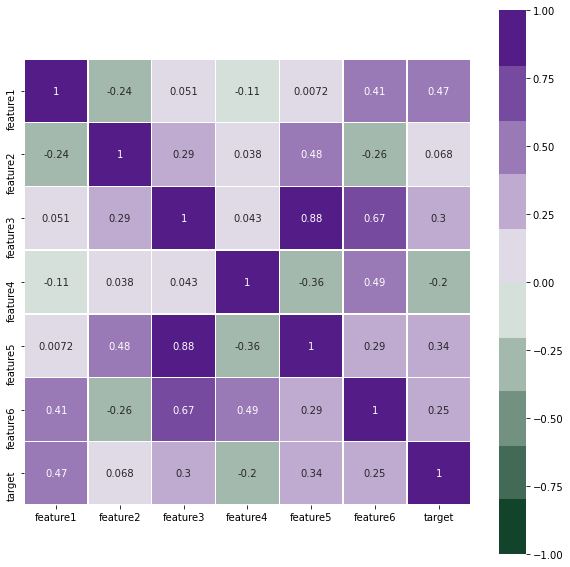

In [5]:
# Establece los límites de colores entre [-1, 1], así como un rango de colores de oscuro a oscuro, pasando por claro (0 correlación)
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=.5);

#### 3.3 Verificar distribución del target
* Como podemos observar el dataset está bastante balanceado, no obstante en la busqueda del mejor modelo, se probó con oversample usando Smote y con random oversampler y undersampler. Ninguna de dichas pruebas dió una mejora en el resultado.

In [6]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(df.loc[:,'feature1':'feature6'], df["target"])

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(df.loc[:,'feature1':'feature6'], df["target"])

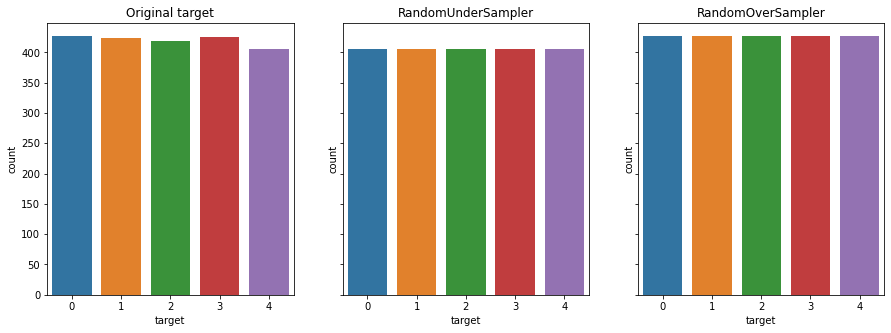

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Original target
sns.countplot(x="target", data=df, ax=axes[0])
axes[0].set_title("Original target")

# RandomUnderSampler
sns.countplot(y_rus, ax=axes[1])
axes[1].set_title("RandomUnderSampler")

# RandomOverSampler
sns.countplot(y_ros, ax=axes[2])
axes[2].set_title("RandomOverSampler");

#### 3.4 Feature importance
 * Como he comentado se valoró reducir la cantidad de features dada la correlación entre la 5 y la 3 y la menor importancia de la 3, no obstante no hubo una mejora en el f1 score.

In [8]:
X = df.loc[:,'feature1':'feature6']
y = df["target"]
names = ["feature1","feature2","feature3","feature4","feature5","feature6"]
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X, y)

scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

,Score,Feature
0,0.2442,feature1
1,0.1863,feature2
2,0.1595,feature6
3,0.1534,feature4
4,0.1375,feature5
5,0.1190,feature3


<a name="Split"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### 4. Train test split
 * Dividiremos el dataframe en train y validation. Así podremos verificar que no tenemos overfit o underfit en el entrenamiento.

In [9]:
# Separamos en train y validation para verificar los resultados del entrenamiento.
X_train, X_validation, y_train, y_validation = train_test_split(X,
                                                                y,
                                                                test_size=0.2,
                                                                random_state=42)

<a name="GridSearch"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### 5. Preparación y ejecución del GridSearch
 5.1 Parámetros del gridsearch , mi idea general sería incluir varios modelos diferentes como puede ser SVC, logisticregresion, y ensemble de voting clasiffier, para ver si mejoran las predicciones. Dado que parece que als reglas solo permiten usar Random Forest no realizaré dicho ensemble.

In [10]:
rand_forest = RandomForestClassifier()

# RANDOM FOREST
grid_random_forest = {"n_estimators": [200, 300, 500, 1000], # El Random Forest no suele empeorar por exceso de
                                             # estimadores. A partir de cierto numero no merece la pena
                                             # perder el tiempo ya que no mejora mucho más la precisión.
                                             # Entre 100 y 200 es una buena cifra

                     
                     "max_depth": [15, 17, 18, 19, 20], # No le afecta tanto el overfitting como al decissiontree.
                                                      # Podemos probar mayores profundidades
                      
                     "max_features": ['sqrt', 2, 3, 4], # Numero de features que utiliza en cada split.
                                                       # cuanto más bajo, mejor generalizará y menos overfitting. 
                     "min_samples_split":[ 2, 3]
                     }

#### 5.2 Realización del GridSearch
He definido un lista con  una tupla, donde de añadir otros algoritmos de machine learning, podria añadirlos a dicha lista para que sea escalable para aplicar todos los gridsearch para cada modelo.

In [11]:
# Almaceno en una lista de tuplas los modelos (nombre que le pongo, el modelo, hiperparametros)
models = [('rand_forest', rand_forest, grid_random_forest)]

# Declaro en un diccionario los pipelines e hiperparametros
models_gridsearch = {}

for i in models:
    models_gridsearch[i[0]] = GridSearchCV(i[1],
                                          i[2],
                                          cv=30,
                                          scoring='f1_macro',
                                          verbose=1,
                                          n_jobs=-1)
    
    models_gridsearch[i[0]].fit(X_train, y_train)

Fitting 30 folds for each of 160 candidates, totalling 4800 fits


#### 5.3 Obtener el mejor modelo
Al igual que en el apartado anterior, el objetido de este código sería obtener la mejor puntuación de cada modelo realizado, en este caso solo de Random Forest.

In [12]:
best_grids = [(i, j.best_score_) for i, j in models_gridsearch.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
0,rand_forest,0.776385


#### 5.4 Obtener mejores parámetros y verificar con validation el score.
De usar otros modelos, solamente habría que cambiar donde poner rand_forest por el modelo ganador, para asi obtener los mejores parámetros del mejor modelo.

In [13]:
# Obtebnemos los parámetros que han dado el mejor performance.
models_gridsearch['rand_forest'].best_estimator_

RandomForestClassifier(max_depth=18, max_features=3, n_estimators=200)

In [14]:
# Probamos en validation
models_gridsearch['rand_forest'].best_estimator_.score(X_validation, y_validation)

0.8023809523809524

<a name="Modelo"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### 6. Entrenamos el modelo con los mejores parámetros

In [15]:
rfc=RandomForestClassifier(max_depth=18, max_features=3, n_estimators=200)

In [16]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, max_features=3, n_estimators=200)

<a name="Predicciones"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### 7. Obtenemos las predicciones de validation

In [18]:
prediction_val=rfc.predict(X_validation)

In [19]:
prediction_val

array([0, 4, 3, 4, 1, 4, 4, 0, 2, 1, 3, 2, 1, 3, 3, 0, 2, 1, 0, 2, 1, 0,
       3, 1, 1, 3, 4, 2, 2, 2, 2, 4, 0, 4, 1, 1, 1, 3, 4, 0, 4, 4, 0, 4,
       3, 1, 0, 0, 0, 0, 0, 4, 2, 3, 2, 3, 3, 2, 4, 1, 2, 1, 1, 4, 1, 3,
       1, 1, 4, 3, 1, 4, 2, 0, 1, 2, 1, 2, 3, 3, 4, 1, 1, 4, 3, 4, 0, 0,
       0, 3, 3, 0, 1, 3, 4, 4, 3, 2, 3, 3, 1, 4, 4, 1, 1, 3, 1, 2, 2, 2,
       0, 1, 3, 3, 3, 3, 2, 4, 4, 2, 4, 2, 4, 3, 2, 3, 3, 0, 4, 0, 1, 2,
       2, 2, 4, 4, 4, 4, 1, 1, 3, 1, 2, 3, 3, 2, 3, 0, 3, 3, 3, 0, 1, 4,
       0, 3, 3, 3, 3, 2, 4, 1, 1, 2, 2, 2, 1, 2, 3, 0, 3, 1, 1, 2, 4, 0,
       4, 4, 0, 1, 2, 2, 4, 1, 1, 1, 4, 2, 2, 0, 1, 2, 1, 4, 4, 1, 4, 3,
       2, 0, 1, 1, 0, 3, 1, 2, 2, 3, 0, 2, 4, 3, 3, 3, 3, 4, 0, 2, 4, 0,
       4, 2, 0, 2, 1, 1, 3, 0, 0, 1, 0, 2, 0, 4, 2, 4, 4, 0, 1, 3, 4, 3,
       1, 3, 1, 3, 3, 2, 2, 2, 1, 0, 0, 3, 2, 2, 1, 1, 0, 0, 2, 0, 0, 0,
       2, 1, 2, 1, 0, 0, 1, 4, 2, 3, 2, 1, 3, 4, 3, 1, 1, 3, 1, 3, 0, 4,
       0, 2, 2, 1, 3, 0, 4, 1, 3, 2, 1, 4, 1, 4, 2,

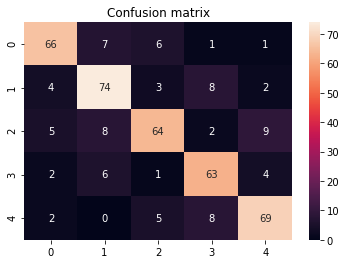

In [20]:
CM = confusion_matrix(y_validation, prediction_val)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()


<a name="Predict_test"></a>
<a href="#init"><p style="text-align:right;" href="#init">Volver al índice</p></a> 
### 8. Predicciones de Test

In [22]:
predic_test = rfc.predict(df_test)
predic_test

array([1, 3, 2, 0, 3, 2, 4, 0, 2, 3, 1, 4, 1, 1, 4, 4, 4, 3, 2, 0, 1, 2,
       3, 0, 0, 3, 0, 2, 2, 4, 2, 2, 4, 1, 3, 1, 0, 4, 3, 0, 4, 2, 3, 2,
       2, 0, 1, 1, 2, 4, 4, 0, 4, 0, 4, 4, 1, 3, 3, 0, 3, 0, 3, 0, 4, 1,
       1, 0, 2, 3, 0, 1, 4, 0, 4, 0, 0, 1, 2, 3, 4, 3, 0, 3, 1, 1, 2, 3,
       1, 2, 2, 4, 1, 1, 0, 1, 4, 2, 0, 4, 0, 0, 0, 4, 2, 4, 4, 4, 1, 2,
       4, 1, 3, 3, 3, 0, 3, 3, 2, 2, 0, 4, 4, 3, 3, 2, 4, 1, 3, 2, 2, 1,
       4, 0, 0, 2, 3, 0, 0, 4, 0, 4, 3, 2, 1, 3, 4, 3, 4, 4, 3, 2, 1, 2,
       0, 4, 0, 2, 4, 2, 0, 2, 3, 1, 1, 4, 0, 3, 2, 0, 1, 2, 4, 4, 1, 2,
       3, 0, 3, 4, 2, 1, 0, 2, 2, 2, 0, 3, 4, 1, 1, 1, 3, 4, 0, 0, 4, 4,
       1, 2, 0, 2, 4, 3, 2, 2, 3, 1, 1, 3, 0, 0, 2, 1, 1, 3, 4, 2, 2, 1,
       2, 2, 2, 0, 3, 0, 0, 2, 2, 3, 0, 2, 4, 3, 2, 4, 0, 3, 3, 3, 0, 4,
       3, 0, 2, 0, 2, 1, 2, 0, 2, 3, 1, 3, 1, 1, 0, 3, 2, 4, 2, 1, 0, 2,
       2, 4, 2, 4, 1, 2, 1, 4, 2, 0, 3, 0, 1, 4, 2, 4, 1, 1, 3, 1, 1, 4,
       0, 0, 2, 2, 3, 1, 0, 2, 0, 0, 4, 4, 1, 3, 0,

In [29]:
df_prediction = pd.DataFrame(data= predic_test, columns=['final_status'])
df_prediction.head()

,final_status
0,1
1,3
2,2
3,0
4,3


In [30]:
df_prediction.to_csv('data/predicciones_test.csv', index=False)